# **Oversampling**

## **Import library & load data**

*   Menggunakan pymysql + SQLAlchemy untuk membaca dataset dari tabel ecoli_dataset yang terhubung di database cloud menggunakan aiven.

*   Data disimpan ke pandas DataFrame.

In [25]:
!pip install pymysql
!pip install pandas
!pip install sqlalchemy
!pip install python-dotenv
!pip install imbalanced-learn


In [26]:
from google.colab import files
uploaded = files.upload()

Saving UCI.env to UCI.env


In [27]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import io

# Load the content of the uploaded .env file
env_content = uploaded['UCI.env'].decode('utf-8')

# Parse the content and set environment variables manually, removing angle brackets
for line in env_content.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        os.environ[key.strip()] = value.strip().replace('<', '').replace('>', '')

# Ambil variabel koneksi dari lingkungan
MYSQL_HOST = os.getenv("MYSQL_HOST")
MYSQL_PORT = os.getenv("MYSQL_PORT")
MYSQL_USER = os.getenv("MYSQL_USER")
MYSQL_PASSWORD = os.getenv("MYSQL_PASSWORD")
MYSQL_DATABASE = os.getenv("MYSQL_DATABASE")

# Gunakan SQLAlchemy untuk koneksi ke MySQL
# Ensure the port is an integer
mysql_engine = create_engine(f"mysql+pymysql://{MYSQL_USER}:{MYSQL_PASSWORD}@{MYSQL_HOST}:{int(MYSQL_PORT)}/{MYSQL_DATABASE}")

# Jalankan query
mysql_query = "SELECT * FROM ecoli_dataset;"
df = pd.read_sql(mysql_query, mysql_engine)

# Print hasil
print("Data dari MySQL:")
print(df.head())

Data dari MySQL:
     sequence   mcg   gvh   lip  chg   aac  alm1  alm2 class
0   AAS_ECOLI  0.44  0.52  0.48  0.5  0.43  0.47  0.54    im
1   AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35    cp
2  ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44    cp
3  ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46    cp
4  ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36    cp


## **Preprocessing Data**

Dari dataset, kolom non-numerik seperti class (label target) dan sequence dihapus dari variabel fitur X. Label kelas class disimpan di y. Selanjutnya, semua fitur numerik pada X distandarisasi dengan MinMaxScaler agar berada pada skala yang sama.

In [28]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Buang kolom non-numerik
X = df.drop(["class", "sequence"], axis=1)
y = df["class"]

## **Data Original**

Kode di bawah digunakan untuk menampilkan distribusi jumlah data pada dataset original (sebelum dilakukan balancing).

1.   Pertama, dilakukan perhitungan jumlah data tiap kelas dengan fungsi `value_counts()`. Hasil perhitungan menunjukkan bahwa dataset terdiri dari 8 kelas dengan jumlah data yang berbeda-beda:

      *   `cp` : 143 data

      *   `im` : 77 data

      *   `pp` : 52 data

      *   `imU`: 35 data

      *   `om` : 20 data

      *   `omL` : 5 data

      *   `imS` : 2 data

      *   `imL` : 2 data

2.   Selanjutnya, dibuat grafik batang menggunakan `Seaborn` untuk memperlihatkan perbandingan jumlah data antar kelas secara visual.

3.   Hasil grafik menunjukkan bahwa distribusi kelas dalam data tidak seimbang (imbalanced).

      *   Kelas mayoritas adalah `cp` dengan 143 data.

      *   Beberapa kelas minoritas seperti `imS, imL`, dan `omL` memiliki jumlah data yang sangat sedikit (≤ 5 data).



Jumlah data per kelas:
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64


/tmp/ipython-input-2550041022.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="tab10")


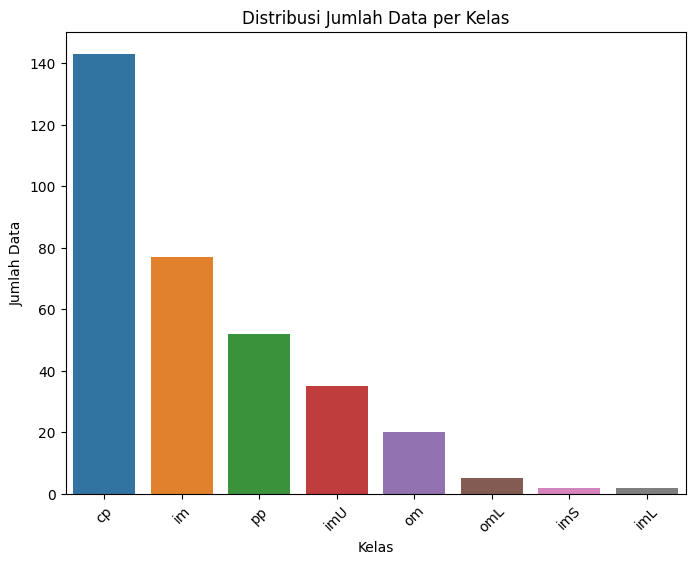

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# ============================
# Jumlah data tiap kelas (angka)
# ============================
class_counts = y.value_counts()
print("Jumlah data per kelas:")
print(class_counts)

# ============================
# Grafik batang distribusi kelas
# ============================
plt.figure(figsize=(8,6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="tab10")
plt.title("Distribusi Jumlah Data per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)
plt.show()

Principal Component Analysis (PCA) digunakan untuk mereduksi dimensi data menjadi 2 komponen utama (PC1 dan PC2). Hasil reduksi divisualisasikan dalam bentuk scatter plot, sehingga distribusi data antar kelas dapat diamati sebelum dilakukan penyeimbangan kelas.

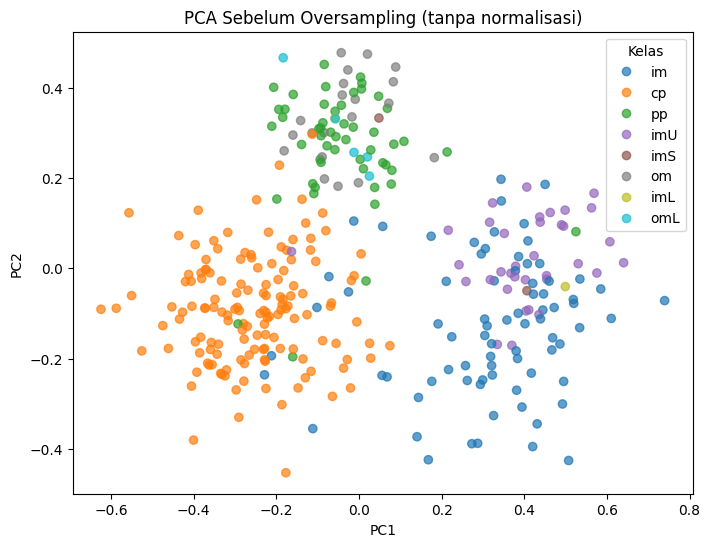

In [30]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=pd.factorize(y)[0], cmap="tab10", alpha=0.7)
plt.title("PCA Sebelum Oversampling (tanpa normalisasi)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Tambahkan legend sesuai kelas
handles, labels = scatter.legend_elements()
class_labels = pd.Series(y).unique()
plt.legend(handles, class_labels, title="Kelas")
plt.show()

### Kesimpulan

Distribusi data original bersifat **imbalanced**, di mana terdapat perbedaan yang cukup signifikan antara jumlah data pada kelas mayoritas dan kelas minoritas. Kondisi ini berpotensi menyebabkan model cenderung lebih baik dalam mengenali kelas mayoritas dibanding kelas minoritas, sehingga perlu dipertimbangkan teknik penyeimbangan data seperti **SMOTE** atau **ADASYN** sebelum pelatihan model.

## **Oversampling dengan SMOTE**

Teknik SMOTE diterapkan untuk menambah jumlah data pada kelas minoritas dengan cara membuat sampel sintetis baru. Karena terdapat kelas yang hanya memiliki sedikit sampel, parameter k_neighbors diset menjadi 1 agar proses tidak gagal. Distribusi kelas setelah oversampling ditampilkan untuk membandingkan dengan kondisi awal.

Distribusi awal: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})
Distribusi setelah SMOTE: Counter({'im': 143, 'cp': 143, 'pp': 143, 'imU': 143, 'imS': 143, 'om': 143, 'imL': 143, 'omL': 143})


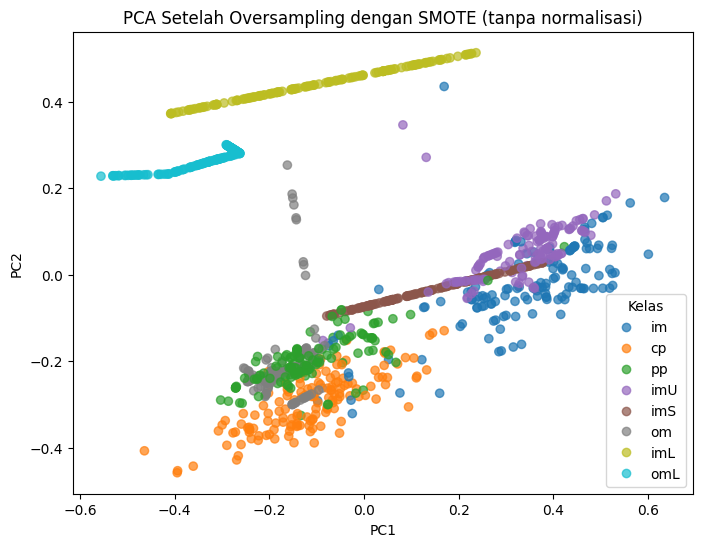

In [31]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

print("Distribusi awal:", Counter(y))

smote = SMOTE(random_state=42, k_neighbors=1)
X_smote, y_smote = smote.fit_resample(X, y)
print("Distribusi setelah SMOTE:", Counter(y_smote))

# PCA setelah SMOTE
pca = PCA(n_components=2)
X_smote_pca = pca.fit_transform(X_smote)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_smote_pca[:, 0], X_smote_pca[:, 1],
                      c=pd.factorize(y_smote)[0], cmap="tab10", alpha=0.7)
plt.title("PCA Setelah Oversampling dengan SMOTE (tanpa normalisasi)")
plt.xlabel("PC1")
plt.ylabel("PC2")

handles, labels = scatter.legend_elements()
class_labels = pd.Series(y_smote).unique()
plt.legend(handles, class_labels, title="Kelas")
plt.show()

## **Oversampling dengan ADASYN**

Selain SMOTE, teknik ADASYN juga dicoba untuk menyeimbangkan kelas. ADASYN bekerja dengan memberikan bobot lebih pada kelas yang sulit dipelajari, sehingga lebih adaptif. Namun, karena dataset ini memiliki kelas yang sangat sedikit, proses ADASYN bisa gagal. Oleh karena itu, dilakukan iterasi dengan penyesuaian nilai n_neighbors agar dapat berjalan. Jika berhasil, distribusi kelas baru ditampilkan.

In [32]:
print("Distribusi kelas sebelum ADASYN:")
print(f"{sorted(Counter(y).items())}")

nt = X
ns = y

class_counts = Counter(y).values()
temp = sorted(class_counts)
print(f"Sorted counts untuk iterasi: {temp}")

for i in range(0, 7):
    n = max(1, temp[i] - 1)

    print(f"\nIterasi {i+1}: menggunakan k_neighbors={n}")

    try:
        nt, ns = ADASYN(n_neighbors=n, sampling_strategy='minority').fit_resample(nt, ns)
        print(f"Hasil iterasi {i+1}: {sorted(Counter(ns).items())}")
    except Exception as e:
        print(f"Error pada iterasi {i+1}: {e}")
        break

print(f"\nDistribusi kelas setelah ADASYN:")
print(f"{sorted(Counter(ns).items())}")

print(f"\nTotal samples sebelum: {len(y)}")
print(f"Total samples setelah: {len(ns)}")
print(f"Data yang ditambahkan: {len(ns) - len(y)}")

Distribusi kelas sebelum ADASYN:
[('cp', 143), ('im', 77), ('imL', 2), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]
Sorted counts untuk iterasi: [2, 2, 5, 20, 35, 52, 77, 143]

Iterasi 1: menggunakan k_neighbors=1
Hasil iterasi 1: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Iterasi 2: menggunakan k_neighbors=1
Hasil iterasi 2: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Iterasi 3: menggunakan k_neighbors=4
Hasil iterasi 3: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 20), ('omL', 143), ('pp', 52)]

Iterasi 4: menggunakan k_neighbors=19
Hasil iterasi 4: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 35), ('om', 143), ('omL', 143), ('pp', 52)]

Iterasi 5: menggunakan k_neighbors=34
Hasil iterasi 5: [('cp', 143), ('im', 77), ('imL', 142), ('imS', 142), ('imU', 144), ('om', 143), ('omL', 143), ('pp', 52)]

Iterasi 

## **Reduksi Dimensi dengan PCA setelah oversampling**

Setelah oversampling (baik SMOTE maupun ADASYN), data kembali direduksi ke dalam 2 dimensi dengan PCA. Scatter plot ditampilkan untuk memperlihatkan distribusi data baru setelah penambahan data sintetis. Visualisasi ini mempermudah perbandingan kondisi sebelum dan sesudah oversampling.

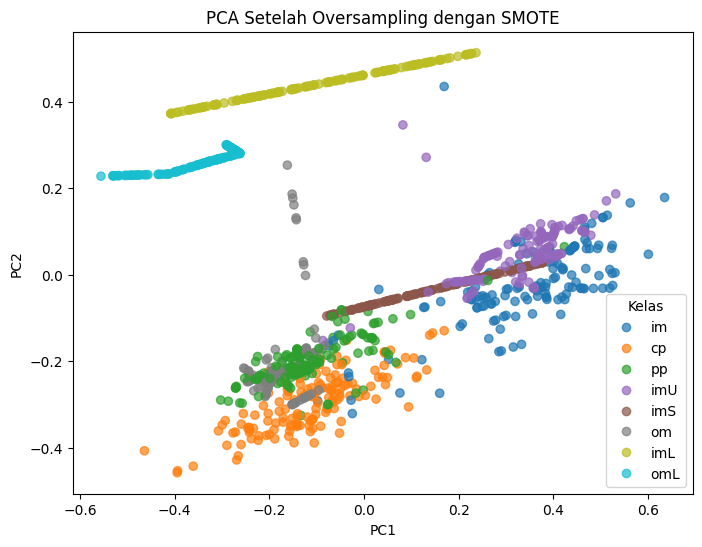

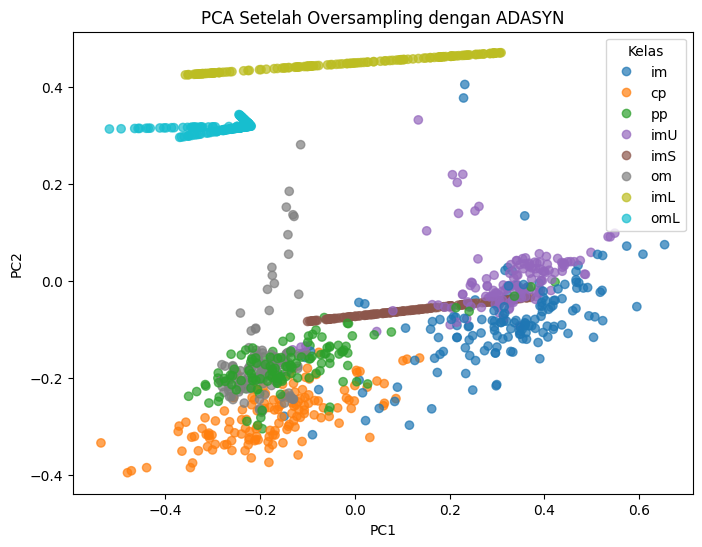

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# ========================
# PCA & Scatter Plot setelah SMOTE
# ========================
pca = PCA(n_components=2)
X_smote_pca = pca.fit_transform(X_smote)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_smote_pca[:, 0], X_smote_pca[:, 1],
                      c=pd.factorize(y_smote)[0], cmap="tab10", alpha=0.7)

# Tambahkan legend sesuai kelas
handles, labels = scatter.legend_elements()
class_labels = pd.Series(y_smote).unique()  # ambil nama kelas unik
plt.legend(handles, class_labels, title="Kelas")

plt.title("PCA Setelah Oversampling dengan SMOTE")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# ========================
# PCA & Scatter Plot setelah ADASYN (jika berhasil)
# ========================
if len(ns) > len(y):  # cek apakah ADASYN berhasil menambah data
    pca = PCA(n_components=2)
    X_adasyn_pca = pca.fit_transform(nt)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_adasyn_pca[:, 0], X_adasyn_pca[:, 1],
                          c=pd.factorize(ns)[0], cmap="tab10", alpha=0.7)

    # Tambahkan legend sesuai kelas
    handles, labels = scatter.legend_elements()
    class_labels = pd.Series(ns).unique()
    plt.legend(handles, class_labels, title="Kelas")

    plt.title("PCA Setelah Oversampling dengan ADASYN")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
else:
    print("⚠️ ADASYN tidak berhasil menambah data, visualisasi dilewati.")


### Hasil data setelah di seimbangkan dengan SMOTE

Kode di bawah digunakan untuk menampilkan distribusi jumlah data setelah dilakukan proses **SMOTE (Synthetic Minority Oversampling Technique)**.

1.   Perhitungan jumlah data per kelas

      Hasil value_counts() menunjukkan bahwa seluruh kelas sekarang memiliki jumlah data yang sama rata, yaitu 143 data per kelas. Dengan demikian, tidak ada lagi perbedaan antara kelas mayoritas maupun minoritas.

2.   Visualisasi distribusi kelas

      Grafik batang memperlihatkan distribusi data yang merata untuk semua kelas (`cp, im, pp, imU, imS, om, imL, omL`). Setiap batang memiliki tinggi yang sama karena jumlah data sudah diseimbangkan oleh **SMOTE**.



Jumlah data per kelas setelah SMOTE:
class
im     143
cp     143
pp     143
imU    143
imS    143
om     143
imL    143
omL    143
Name: count, dtype: int64


/tmp/ipython-input-2819008724.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_smote.value_counts().index,


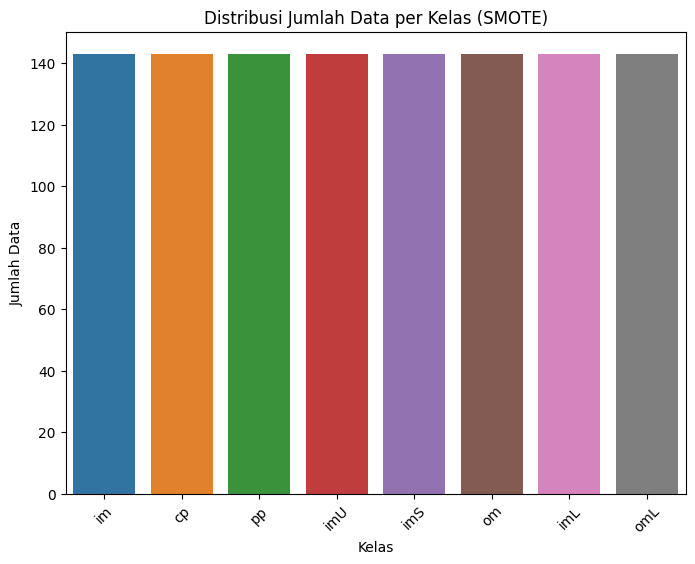

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\nJumlah data per kelas setelah SMOTE:")
print(y_smote.value_counts())

plt.figure(figsize=(8,6))
sns.barplot(x=y_smote.value_counts().index,
            y=y_smote.value_counts().values,
            palette="tab10")
plt.title("Distribusi Jumlah Data per Kelas (SMOTE)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)
plt.show()

### Hasil data setelah di seimbangkan dengan ADASYN

Kode di bawah digunakan untuk menampilkan distribusi jumlah data setelah dilakukan proses **ADASYN (Adaptive Synthetic Sampling)**.

1.   Perhitungan jumlah data per kelas

      Hasil `value_counts()` menunjukkan bahwa distribusi data sudah jauh lebih seimbang dibandingkan data original. Jumlah data tiap kelas hampir merata, meskipun tidak persis sama:

      *   `im` : 149 data
      
      *   `imU` : 144 data

      *   `cp, om, omL` : masing-masing 143 data
      
      *   `pp, imS, imL` : masing-masing 142 data

      Dengan ADASYN, kelas minoritas ditambahkan data sintetis secara adaptif, sehingga jumlahnya mendekati kelas mayoritas.

2.   Visualisasi distribusi kelas

      Grafik batang memperlihatkan distribusi kelas yang hampir seragam. Tidak ada kelas yang sangat dominan atau sangat sedikit seperti pada data original. Meskipun terdapat sedikit variasi (142–149 data per kelas), perbedaan tersebut relatif kecil.



Jumlah data per kelas setelah ADASYN:
class
im     149
imU    144
cp     143
om     143
omL    143
pp     142
imS    142
imL    142
Name: count, dtype: int64


/tmp/ipython-input-1772876076.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pd.Series(ns).value_counts().index,


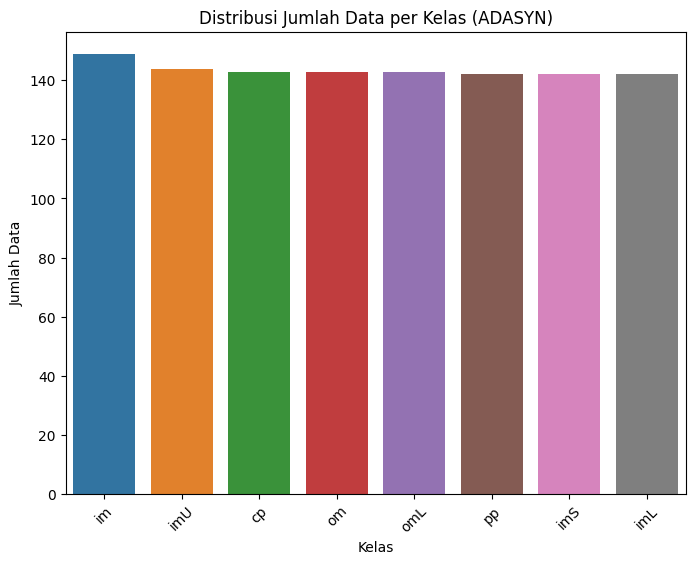

In [35]:
if 'ns' in locals():
    print("\nJumlah data per kelas setelah ADASYN:")
    print(pd.Series(ns).value_counts())

    plt.figure(figsize=(8,6))
    sns.barplot(x=pd.Series(ns).value_counts().index,
                y=pd.Series(ns).value_counts().values,
                palette="tab10")
    plt.title("Distribusi Jumlah Data per Kelas (ADASYN)")
    plt.xlabel("Kelas")
    plt.ylabel("Jumlah Data")
    plt.xticks(rotation=45)
    plt.show()

## **Klasifikasi**

Klasifikasi merupakan salah satu metode dalam machine learning yang digunakan untuk memprediksi **label kelas** dari suatu data berdasarkan pola yang dipelajari dari data latih (training data). Tujuan dari klasifikasi adalah agar model mampu mengelompokkan data baru ke dalam kategori yang tepat.

Dalam penelitian ini, klasifikasi dilakukan menggunakan beberapa algoritma dan pendekatan:

1.   Naive Bayes

      *   Merupakan algoritma berbasis probabilitas yang menggunakan teorema Bayes dengan asumsi bahwa setiap fitur bersifat independen.

      *   Cocok digunakan untuk dataset dengan dimensi tinggi, sederhana, dan cepat dalam perhitungan.

2.   Random Forest

      *   Algoritma berbasis ensemble learning yang membangun banyak decision tree secara acak, kemudian menggabungkan hasil prediksi dari setiap pohon untuk mendapatkan hasil akhir.

      *   Metode ini biasanya lebih stabil dan akurat karena mengurangi risiko overfitting.

3.   Ensemble Bagging

      *   Teknik ensemble yang membangun beberapa model dengan data latih yang diambil secara bootstrap (sampel acak dengan pengembalian).

      *   Tujuannya adalah mengurangi variansi dan meningkatkan akurasi prediksi.

      *   Dalam penelitian ini, Bagging digunakan dengan dua model dasar: Naive Bayes dan Random Forest.

### **Naive Bayes**

Naive Bayes merupakan algoritma klasifikasi berbasis probabilitas yang menggunakan **Teorema Bayes** dengan asumsi bahwa setiap fitur saling independen. Algoritma ini dikenal sederhana, cepat, dan cukup efektif, terutama pada data berdimensi tinggi.

Pada percobaan ini, Naive Bayes diterapkan pada tiga kondisi dataset: **data asli**, **data hasil SMOTE**, dan **data hasil ADASYN**. Evaluasi dilakukan menggunakan dua metrik, yaitu **akurasi** dan **F1-score**.

1.   Data Asli

      *   Akurasi: **0.853**

      *   F1-score: **0.847**

      *   Hasil ini menunjukkan bahwa Naive Bayes bekerja cukup baik pada distribusi data asli meskipun dataset awal tidak seimbang.

2.   Data SMOTE

      *   Akurasi: **0.790**

      *   F1-score: **0.749**

      *   Performa menurun setelah data diseimbangkan menggunakan SMOTE. Hal ini dapat terjadi karena SMOTE menghasilkan sampel sintetis yang membuat asumsi independensi antar fitur pada Naive Bayes menjadi kurang sesuai, sehingga memengaruhi kualitas prediksi.

3.   Data ADASYN

      *   Akurasi: **0.826**

      *   F1-score: **0.822**

      *   Hasil dengan ADASYN lebih baik dibandingkan SMOTE, meskipun masih sedikit di bawah data asli. ADASYN menambahkan data sintetis lebih adaptif pada kelas minoritas, sehingga model dapat belajar lebih seimbang dibandingkan dengan SMOTE.

In [43]:
# ==========================
# Naive Bayes
# ==========================
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# --------------------------
# Data asli
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

naive_ori = accuracy_score(y_test, y_pred)
f1_ori = f1_score(y_test, y_pred, average="weighted")
print("=== Naive Bayes - Data Asli ===")
print("Akurasi :", naive_ori)
print("F1 Score:", f1_ori)

# --------------------------
# Data SMOTE
# --------------------------
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

nb_smote = GaussianNB()
nb_smote.fit(X_sm_train, y_sm_train)
y_sm_pred = nb_smote.predict(X_sm_test)

naive_smote = accuracy_score(y_sm_test, y_sm_pred)
f1_smote = f1_score(y_sm_test, y_sm_pred, average="weighted")
print("\n=== Naive Bayes - Data SMOTE ===")
print("Akurasi :", naive_smote)
print("F1 Score:", f1_smote)

# --------------------------
# Data ADASYN
# --------------------------
X_ad_train, X_ad_test, y_ad_train, y_ad_test = train_test_split(
    nt, ns, test_size=0.2, random_state=42, stratify=ns
)

nb_adasyn = GaussianNB()
nb_adasyn.fit(X_ad_train, y_ad_train)
y_ad_pred = nb_adasyn.predict(X_ad_test)

naive_adasyn = accuracy_score(y_ad_test, y_ad_pred)
f1_adasyn = f1_score(y_ad_test, y_ad_pred, average="weighted")
print("\n=== Naive Bayes - Data ADASYN ===")
print("Akurasi :", naive_adasyn)
print("F1 Score:", f1_adasyn)

# --------------------------
# Ringkasan hasil NB
# --------------------------
hasil_nb = pd.DataFrame({
    "Dataset": ["Asli", "SMOTE", "ADASYN"],
    "Akurasi NB": [naive_ori, naive_smote, naive_adasyn],
    "F1 Score NB": [f1_ori, f1_smote, f1_adasyn]
})

print("\nRingkasan Perbandingan Naive Bayes:")
print(hasil_nb)

=== Naive Bayes - Data Asli ===
Akurasi : 0.8529411764705882
F1 Score: 0.8469871111687042

=== Naive Bayes - Data SMOTE ===
Akurasi : 0.7903930131004366
F1 Score: 0.7487888762232741

=== Naive Bayes - Data ADASYN ===
Akurasi : 0.8260869565217391
F1 Score: 0.8221135943049735

Ringkasan Perbandingan Naive Bayes:
  Dataset  Akurasi NB  F1 Score NB
0    Asli    0.852941     0.846987
1   SMOTE    0.790393     0.748789
2  ADASYN    0.826087     0.822114


### **Random Forest**

Metode Random Forest digunakan sebagai algoritma klasifikasi untuk membandingkan kinerja model pada tiga skenario dataset, yaitu data asli, data setelah dilakukan oversampling dengan SMOTE, dan data setelah dilakukan oversampling dengan ADASYN.

1.   Data Asli

      Pada data asli, Random Forest menghasilkan akurasi sebesar **0.8971** atau sekitar **89.71%**. Nilai ini menunjukkan bahwa model sudah cukup baik dalam mengenali pola, meskipun terdapat ketidakseimbangan kelas pada data.

2.   Data dengan SMOTE

      Setelah dilakukan penyeimbangan data menggunakan SMOTE, akurasi model meningkat signifikan menjadi **0.9738** atau sekitar **97.38%**. Hal ini menandakan bahwa SMOTE berhasil membantu model belajar lebih seimbang dari setiap kelas, sehingga prediksi menjadi lebih akurat.

3.   Data dengan ADASYN

      Pada data yang diseimbangkan menggunakan **ADASYN**, akurasi model juga meningkat menjadi **0.9609** atau sekitar **96.09%**. Meskipun hasilnya tidak setinggi SMOTE, metode ini tetap menunjukkan perbaikan performa dibandingkan data asli.

In [44]:
# ==========================
# Random Forest
# ==========================
from sklearn.ensemble import RandomForestClassifier

# --------------------------
# Data Asli
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_ori = rf.predict(X_test)
random_ori = accuracy_score(y_test, y_pred_ori)

# --------------------------
# Data SMOTE
# --------------------------
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_sm_train, y_sm_train)
y_pred_smote = rf_smote.predict(X_sm_test)
random_smote = accuracy_score(y_sm_test, y_pred_smote)

# --------------------------
# Data ADASYN
# --------------------------
X_ad_train, X_ad_test, y_ad_train, y_ad_test = train_test_split(
    nt, ns, test_size=0.2, random_state=42, stratify=ns
)

rf_adasyn = RandomForestClassifier(random_state=42)
rf_adasyn.fit(X_ad_train, y_ad_train)
y_pred_adasyn = rf_adasyn.predict(X_ad_test)
random_adasyn = accuracy_score(y_ad_test, y_pred_adasyn)

# --------------------------
# Ringkasan hasil RF
# --------------------------
hasil_rf = pd.DataFrame({
    "Dataset": ["Asli", "SMOTE", "ADASYN"],
    "Akurasi Random Forest": [random_ori, random_smote, random_adasyn]
})

print("\nRingkasan Perbandingan Random Forest:")
print(hasil_rf)



Ringkasan Perbandingan Random Forest:
  Dataset  Akurasi Random Forest
0    Asli               0.897059
1   SMOTE               0.973799
2  ADASYN               0.960870


### **Ensemble Bagging**

1.   **Naive Bayes**

      Metode Bagging (Bootstrap Aggregating) dengan Naive Bayes (GaussianNB) digunakan untuk mengevaluasi kinerja klasifikasi pada tiga skenario dataset, yaitu data asli, data hasil oversampling SMOTE, dan data hasil oversampling ADASYN.

      *   Data Asli

          Pada data asli, model Bagging Naive Bayes menghasilkan **akurasi sebesar 85.29%** dengan **F1-Score 84.65%**. Nilai ini menunjukkan bahwa model mampu melakukan klasifikasi dengan baik meskipun data masih mengalami ketidakseimbangan antar kelas.

      *   Data dengan SMOTE

          Setelah dilakukan oversampling dengan SMOTE, performa model justru menurun, dengan **akurasi sebesar 78.17%** dan F1-Score **74.24%**. Hal ini mengindikasikan bahwa SMOTE kurang cocok diterapkan pada Bagging Naive Bayes, kemungkinan karena distribusi data sintetis yang dihasilkan tidak sesuai dengan asumsi distribusi probabilistik dari Naive Bayes.

      *   Data dengan ADASYN

          Pada data hasil oversampling dengan ADASYN, performa model sedikit lebih baik dibandingkan SMOTE, dengan **akurasi 83.91%** dan **F1-Score 83.72%**. Meskipun belum dapat melampaui performa data asli, ADASYN memberikan hasil yang lebih stabil dibandingkan SMOTE.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# ======================
# Data Asli
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

bag_nb_ori = BaggingClassifier(estimator=GaussianNB(), n_estimators=50, random_state=42)
bag_nb_ori.fit(X_train, y_train)
y_pred_nb_ori = bag_nb_ori.predict(X_test)

acc_nb_ori = accuracy_score(y_test, y_pred_nb_ori)
f1_nb_ori = f1_score(y_test, y_pred_nb_ori, average="weighted")

# ======================
# Data SMOTE
# ======================
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

bag_nb_sm = BaggingClassifier(estimator=GaussianNB(), n_estimators=50, random_state=42)
bag_nb_sm.fit(X_sm_train, y_sm_train)
y_pred_nb_sm = bag_nb_sm.predict(X_sm_test)

acc_nb_sm = accuracy_score(y_sm_test, y_pred_nb_sm)
f1_nb_sm = f1_score(y_sm_test, y_pred_nb_sm, average="weighted")

# ======================
# Data ADASYN
# ======================
X_ad_train, X_ad_test, y_ad_train, y_ad_test = train_test_split(
    nt, ns, test_size=0.2, random_state=42, stratify=ns
)

bag_nb_ad = BaggingClassifier(estimator=GaussianNB(), n_estimators=50, random_state=42)
bag_nb_ad.fit(X_ad_train, y_ad_train)
y_pred_nb_ad = bag_nb_ad.predict(X_ad_test)

acc_nb_ad = accuracy_score(y_ad_test, y_pred_nb_ad)
f1_nb_ad = f1_score(y_ad_test, y_pred_nb_ad, average="weighted")

# ======================
# Ringkasan Hasil
# ======================
hasil_nb = pd.DataFrame({
    "Dataset": ["Asli", "SMOTE", "ADASYN"],
    "Accuracy NB": [acc_nb_ori, acc_nb_sm, acc_nb_ad],
    "F1-Score NB": [f1_nb_ori, f1_nb_sm, f1_nb_ad],
})

print("=== Hasil Bagging Naive Bayes ===")
print(hasil_nb)


/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naiv

=== Hasil Bagging Naive Bayes ===
  Dataset  Accuracy NB  F1-Score NB
0    Asli     0.852941     0.846512
1   SMOTE     0.781659     0.742375
2  ADASYN     0.839130     0.837221


2.   **Random Forest**

      Metode Bagging (Bootstrap Aggregating) dengan Random Forest digunakan untuk menguji performa klasifikasi pada tiga skenario dataset, yaitu data asli, data hasil oversampling SMOTE, dan data hasil oversampling ADASYN.

      *   Data Asli

          Pada data asli, model menghasilkan **akurasi sebesar 91.18%** dengan **F1-Score 90.77%**. Nilai ini menunjukkan bahwa Bagging Random Forest memiliki performa yang tinggi dalam menangani data dengan kondisi distribusi kelas yang tidak seimbang.

      *   Data dengan SMOTE

          Setelah dilakukan oversampling menggunakan SMOTE, performa model meningkat signifikan dengan **akurasi mencapai 96.94%** dan **F1-Score 96.93%**. Hal ini menunjukkan bahwa data sintetis dari SMOTE membantu memperbaiki ketidakseimbangan kelas sehingga model mampu melakukan klasifikasi lebih baik.

      *   Data dengan ADASYN

          Hasil klasifikasi dengan ADASYN juga menunjukkan performa yang tinggi, dengan akurasi **94.78%** dan **F1-Score 94.75%**. Meskipun sedikit lebih rendah dibandingkan SMOTE, metode ADASYN tetap mampu memberikan perbaikan performa yang signifikan dibandingkan data asli.

In [46]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# ======================
# Data Asli
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

bag_rf_ori = BaggingClassifier(estimator=RandomForestClassifier(random_state=42),
                               n_estimators=50, random_state=42)
bag_rf_ori.fit(X_train, y_train)
y_pred_rf_ori = bag_rf_ori.predict(X_test)

acc_rf_ori = accuracy_score(y_test, y_pred_rf_ori)
f1_rf_ori = f1_score(y_test, y_pred_rf_ori, average="weighted")

# ======================
# Data SMOTE
# ======================
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

bag_rf_sm = BaggingClassifier(estimator=RandomForestClassifier(random_state=42),
                              n_estimators=50, random_state=42)
bag_rf_sm.fit(X_sm_train, y_sm_train)
y_pred_rf_sm = bag_rf_sm.predict(X_sm_test)

acc_rf_sm = accuracy_score(y_sm_test, y_pred_rf_sm)
f1_rf_sm = f1_score(y_sm_test, y_pred_rf_sm, average="weighted")

# ======================
# Data ADASYN
# ======================
X_ad_train, X_ad_test, y_ad_train, y_ad_test = train_test_split(
    nt, ns, test_size=0.2, random_state=42, stratify=ns
)

bag_rf_ad = BaggingClassifier(estimator=RandomForestClassifier(random_state=42),
                              n_estimators=50, random_state=42)
bag_rf_ad.fit(X_ad_train, y_ad_train)
y_pred_rf_ad = bag_rf_ad.predict(X_ad_test)

acc_rf_ad = accuracy_score(y_ad_test, y_pred_rf_ad)
f1_rf_ad = f1_score(y_ad_test, y_pred_rf_ad, average="weighted")

# ======================
# Ringkasan Hasil
# ======================
hasil_rf = pd.DataFrame({
    "Dataset": ["Asli", "SMOTE", "ADASYN"],
    "Accuracy RF": [acc_rf_ori, acc_rf_sm, acc_rf_ad],
    "F1-Score RF": [f1_rf_ori, f1_rf_sm, f1_rf_ad],
})

print("=== Hasil Bagging Random Forest ===")
print(hasil_rf)


=== Hasil Bagging Random Forest ===
  Dataset  Accuracy RF  F1-Score RF
0    Asli     0.911765     0.907667
1   SMOTE     0.969432     0.969333
2  ADASYN     0.947826     0.947483


### **Kesimpulan**

*   **Naive Bayes** bekerja lebih baik pada data original, tetapi performanya cenderung menurun setelah data diseimbangkan.

*   **Random Forest** justru mendapatkan peningkatan signifikan pada data hasil **SMOTE** dan **ADASYN**, karena lebih mampu memanfaatkan distribusi kelas yang seimbang.

*   **Bagging Random** Forest menunjukkan hasil paling stabil dan unggul dibandingkan metode lainnya.

Dengan demikian, proses **oversampling** (SMOTE/ADASYN) dan penggunaan **ensemble learning** (Random Forest, Bagging) dapat meningkatkan performa klasifikasi pada dataset yang mengalami ketidakseimbangan kelas.


In [47]:
import pandas as pd

# =======================
# Kumpulkan semua hasil
# =======================

# Naive Bayes
hasil_nb_ori = naive_ori      # hasil akurasi NB data asli
hasil_nb_sm = naive_smote     # hasil akurasi NB SMOTE
hasil_nb_ad = naive_adasyn    # hasil akurasi NB ADASYN

# Random Forest
hasil_rf_ori = random_ori      # hasil akurasi RF data asli
hasil_rf_sm = random_smote     # hasil akurasi RF SMOTE
hasil_rf_ad = random_adasyn    # hasil akurasi RF ADASYN

# Bagging NB
hasil_bnb_ori = acc_nb_ori
hasil_bnb_sm = acc_nb_sm
hasil_bnb_ad = acc_nb_ad

# Bagging RF
hasil_brf_ori = acc_rf_ori
hasil_brf_sm = acc_rf_sm
hasil_brf_ad = acc_rf_ad

# =======================
# Buat DataFrame perbandingan
# =======================
comparison = pd.DataFrame({
    ("Accuracy", "Asli"): {
        "Naive Bayes": hasil_nb_ori,
        "Random Forest": hasil_rf_ori,
        "Bagging (NB)": hasil_bnb_ori,
        "Bagging (RF)": hasil_brf_ori,
    },
    ("Accuracy", "SMOTE"): {
        "Naive Bayes": hasil_nb_sm,
        "Random Forest": hasil_rf_sm,
        "Bagging (NB)": hasil_bnb_sm,
        "Bagging (RF)": hasil_brf_sm,
    },
    ("Accuracy", "ADASYN"): {
        "Naive Bayes": hasil_nb_ad,
        "Random Forest": hasil_rf_ad,
        "Bagging (NB)": hasil_bnb_ad,
        "Bagging (RF)": hasil_brf_ad,
    },
})

# Supaya tampil rapi multi-level kolom
comparison.columns = pd.MultiIndex.from_tuples(comparison.columns)

# Tampilkan tabel akhir
print(comparison)


               Accuracy                    
                   Asli     SMOTE    ADASYN
Naive Bayes    0.852941  0.790393  0.826087
Random Forest  0.897059  0.973799  0.960870
Bagging (NB)   0.852941  0.781659  0.839130
Bagging (RF)   0.911765  0.969432  0.947826
